In [1]:
import sys
import os
changed_dir = False
if(not changed_dir):
    os.chdir(os.path.join(os.getcwd(), "../"))
    sys.path.append(os.getcwd())
    print(os.getcwd())
    changed_dir = True

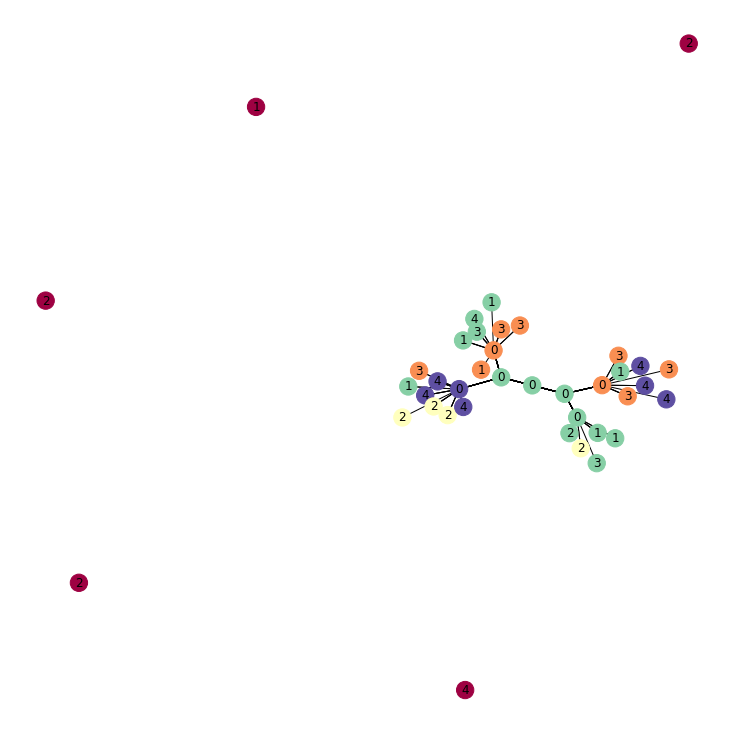

In [2]:
'''
Goal: Find best overlay for a given input
'''
import numpy as np
import random
import math
import time
import ipdb
import traceback

from input import dc_topology, eps0
from main import solve
from config import common_config
from common import setup_logging, Namespace
import matplotlib.pyplot as plt

def flatten(l):
    ret = []
    for x in l:
        if(isinstance(x, list)):
            ret.extend(flatten(x))
        else:
            ret.append(x)
    return ret


INP = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
                  overlay='tor', refine=True,
                  queries_per_tenant=40)
x0 = np.array(flatten(INP.overlay))

ELEMENTS_PER_PART = 8
NITER = 500

OPT = 2105
SPECTRALA = 2134
TENANT = 2135
TOR = 2295
RANDOM = 2315

TSTART = (RANDOM - OPT) / 2
TSTOP = 5

common_config.solver = 'Netmon'
common_config.vertical_partition = True
common_config.prog_dir = None
setup_logging(common_config)


class Anneal():

    def __init__(self, func, x0, Tstart, Tstop, take_step,
                 alpha=0.995, niter=100, callback=None):
        self.func = func
        self.x0 = x0
        self.Tstart = Tstart
        self.Tstop = Tstop
        self.niter = niter
        self.take_step = take_step
        self.alpha = alpha
        self.callback = callback

    def accept_reject(self, energy_new, energy_old):
        if(energy_new < energy_old):
            return True
        else:
            # import ipdb; ipdb.set_trace()
            # print("DeltaE: {}".format(energy_new - energy_old))
            # print("Exp: {}".format( -(energy_new - energy_old)/self.T ))
            # print("Prob: {}".format(math.exp(
            #     -(energy_new - energy_old)/self.T)))
            return random.random() <= math.exp(
                -(energy_new - energy_old)/self.T
            )

    def anneal(self):

        x = self.x0
        f = self.func(x)
        if(getattr(self, 'callback', None)):
            self.callback(x, f, True)

        self.iteration = 0
        self.T = self.Tstart
        while self.T >= self.Tstop and self.iteration < self.niter:

            x_after_step = np.copy(x)
            x_after_step = self.take_step(x_after_step)
            f_after_step = self.func(x_after_step)
            accept = self.accept_reject(f_after_step, f)

            if(getattr(self, 'callback', None)):
                val = self.callback(x_after_step, f_after_step, accept)
                if(val):
                    break

            if(accept):
                f = f_after_step
                x = x_after_step

            self.T *= self.alpha
            self.iteration += 1


class TakeStep():
    def __init__(self, stepsize=1):
        self.stepsize = stepsize

    def __call__(self, perm):
        n = len(perm)
        l = random.randint(2, int((n - 1) * self.stepsize))
        i = random.randint(0, n - l)
        perm = perm.tolist()
        perm[i: (i + l)] = reversed(perm[i: (i + l)])
        return np.array(perm)


class Callback():
    def __init__(self):
        self.data = []
        self.best = Namespace(x=x0, f=func(x0))

    def __call__(self, x, f, accept):
        print(x, f, accept)
        self.data.append(tuple((x, f, accept)))
        if(accept):
            if(f < self.best.f):
                self.best.x = x
                self.best.f = f

        if(abs(f - OPT) < TSTOP):
            return True


# No side effects
def get_overlay_from_perm(perm):
    n = len(perm)
    split_parts = math.floor(n/ELEMENTS_PER_PART)
    covered_elements = split_parts * ELEMENTS_PER_PART
    splits = np.split(
        perm[:covered_elements],
        split_parts)
    splits = [x.astype(int).tolist() for x in splits]
    splits.append(perm[covered_elements:].astype(int).tolist())
    return splits


def func(perm):
    INP.overlay = get_overlay_from_perm(perm)
    # start = time.time()
    r = solve(INP)
    # print(ns, res)
    # end = time.time()
    return r.res  # ((res + 10000) * ns)/1000

In [ ]:
cb = Callback()
ts = TakeStep()
simanneal = Anneal(func, x0,
                   take_step=ts, callback=cb, Tstart=TSTART, Tstop=TSTOP,
                   niter=NITER)
simanneal.anneal()
print(cb.best)

Using license file /home/anupa/gurobi.lic
Academic license - for non-commercial use only


In [4]:
get_overlay_from_perm(x0)

[[0, 1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 13, 14, 15],
 [16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31],
 [32, 33, 34, 35, 36, 37, 38]]

In [18]:
import input
from input import draw_overlay_over_tenant, draw_graph

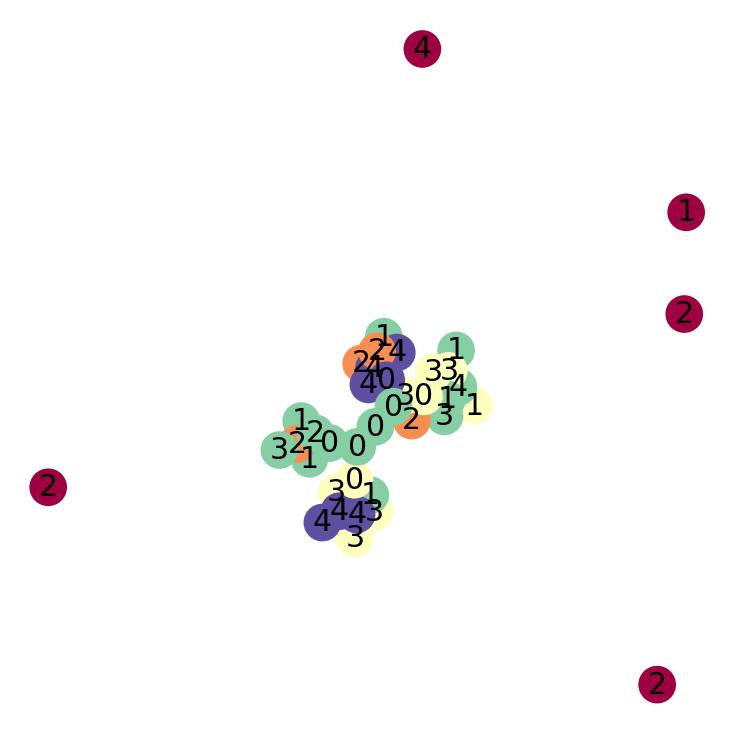

<module 'input' from '/home/anupa/Netmon/NetMon-query-planner/gurobi/input.py'>

In [24]:
import importlib
importlib.reload(input)

In [5]:
ov = get_overlay_from_perm(cb.best.x)
ov

NameError: name 'cb' is not defined

In [4]:
INP.overlay = ov
draw_overlay_over_tenant(INP)

NameError: name 'ov' is not defined

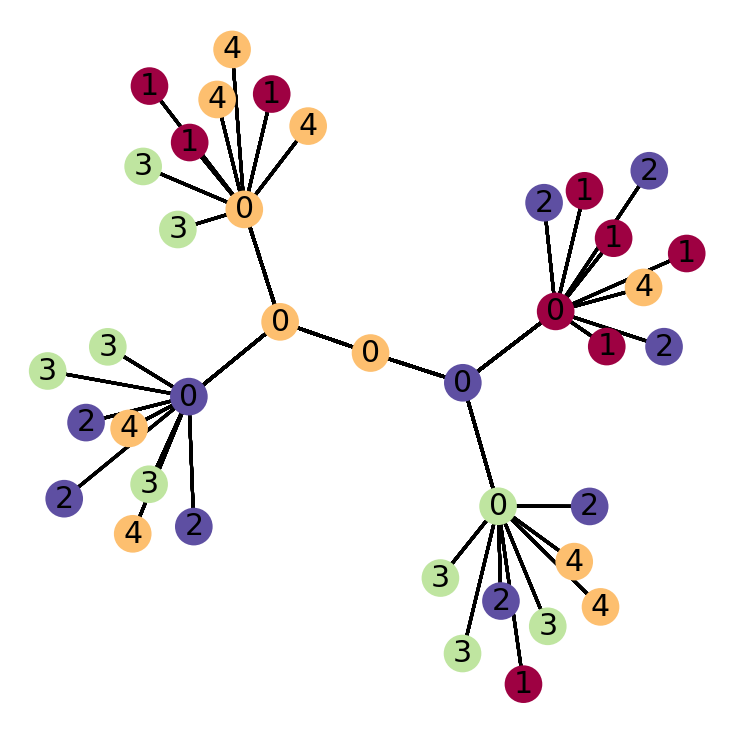

In [26]:
specA = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
            overlay='spectralA', refine=True,
            queries_per_tenant=40)
draw_overlay_over_tenant(specA)

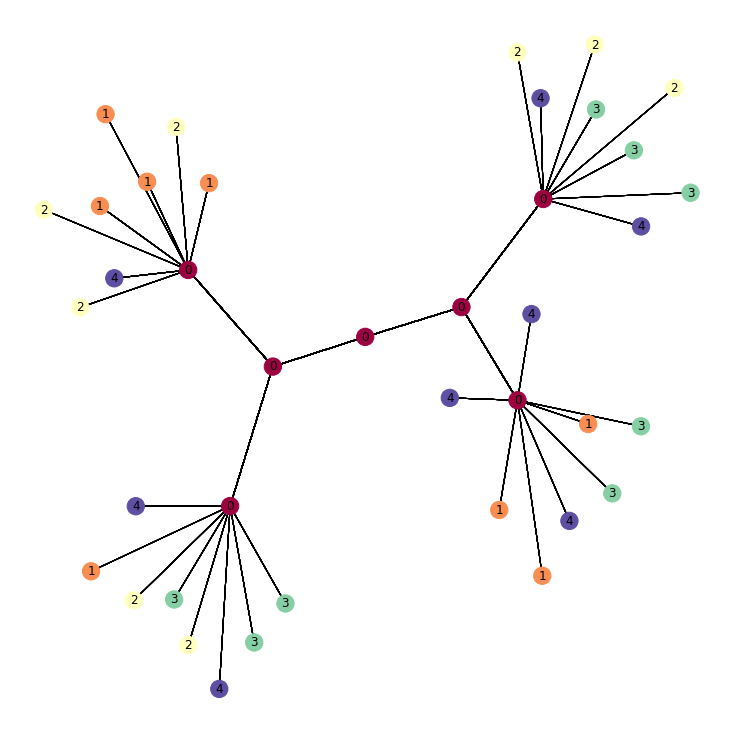

In [5]:
ten = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
            overlay='tenant', refine=True,
            queries_per_tenant=40)
draw_overlay_over_tenant(ten)

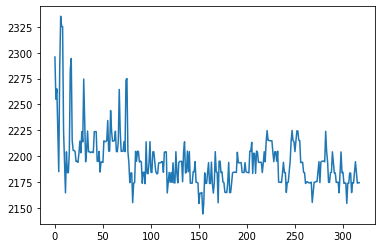

In [11]:
# import pickle
# cb_file = open('pickle_objs/cb', 'wb')
# pickle.dump(cb, cb_file)
# cb_file.close()
plt.plot([x[1] for x in cb.data if x[2]])

cb.data.sort(key=lambda x: x[1])

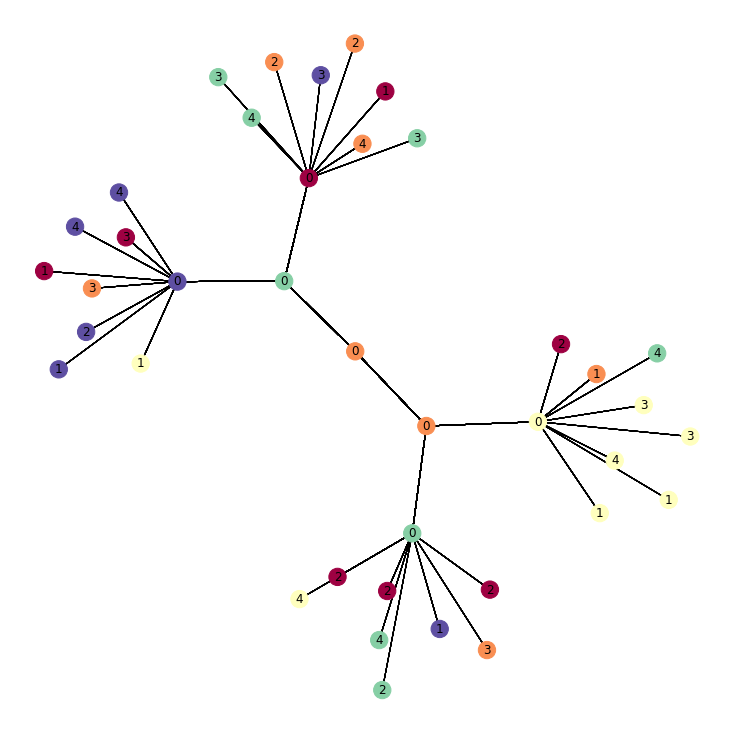

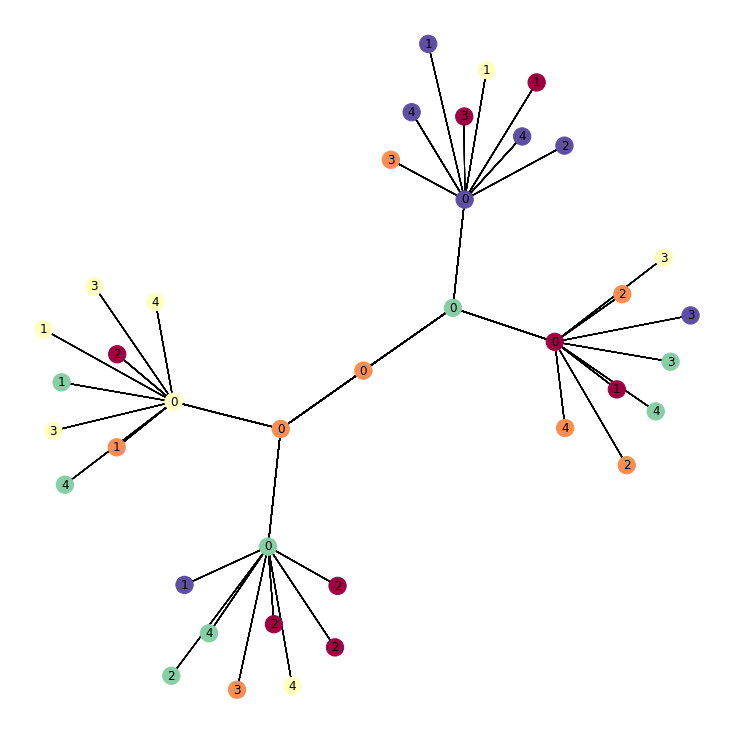

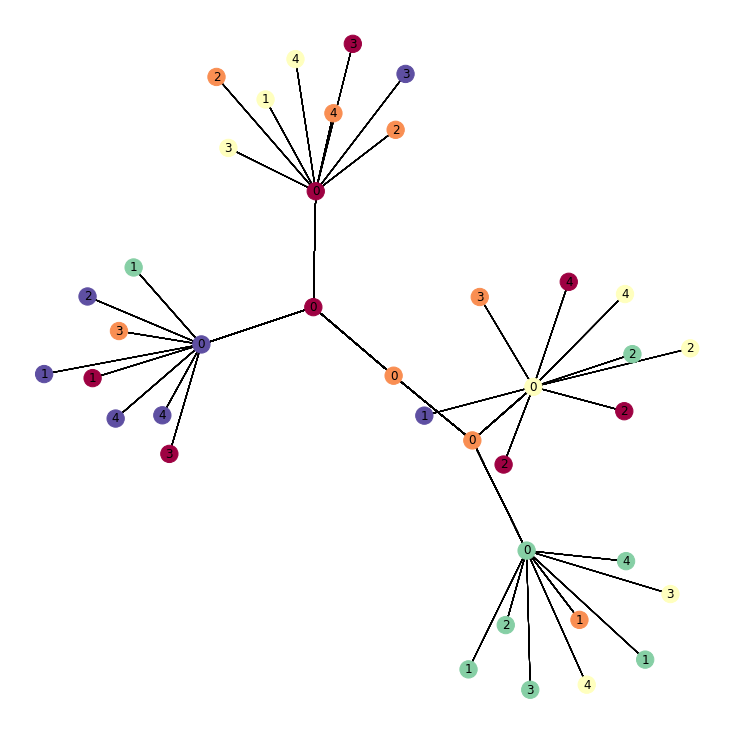

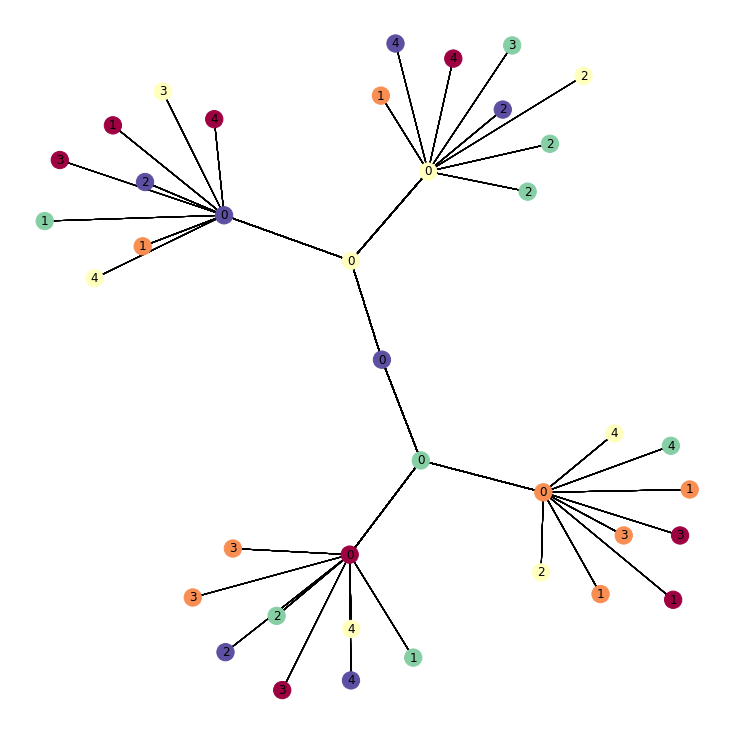

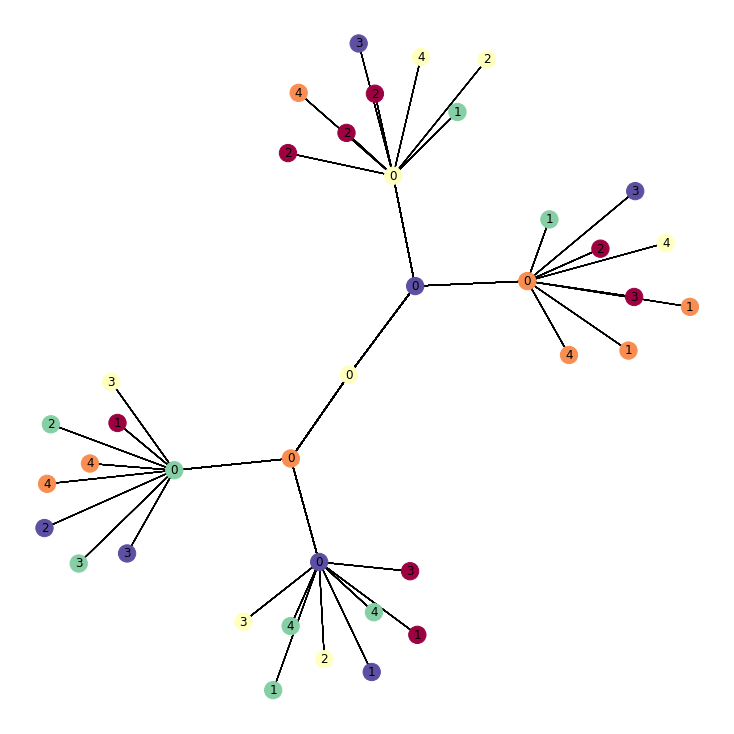

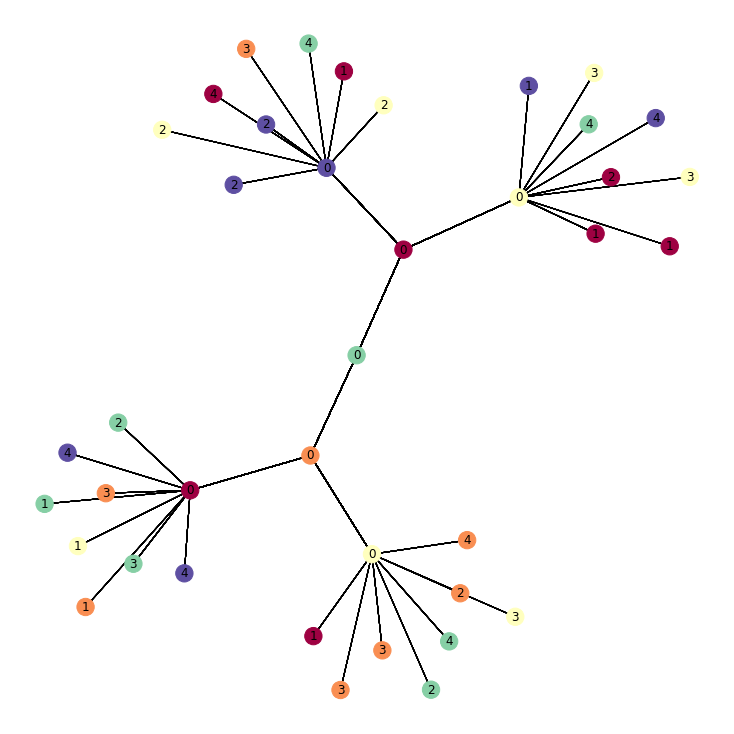

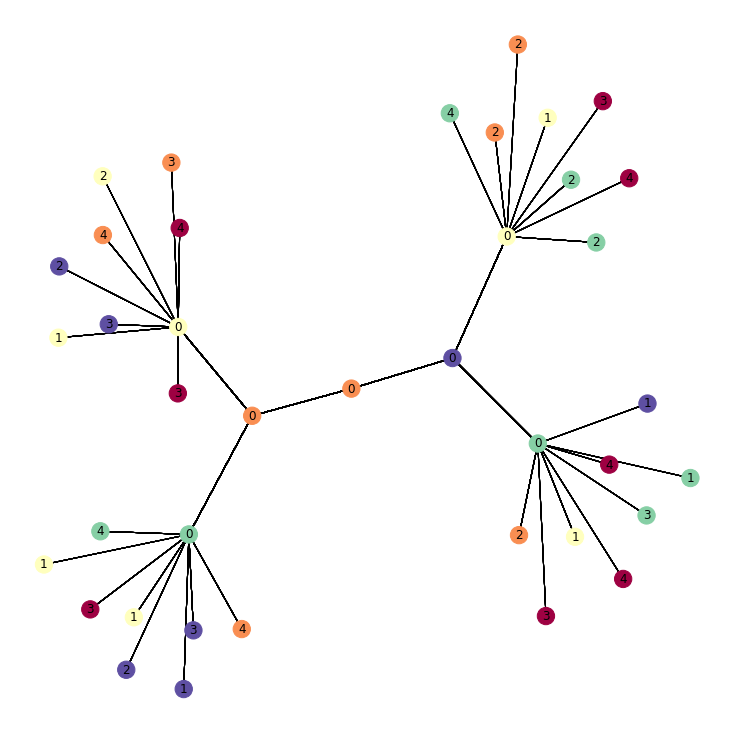

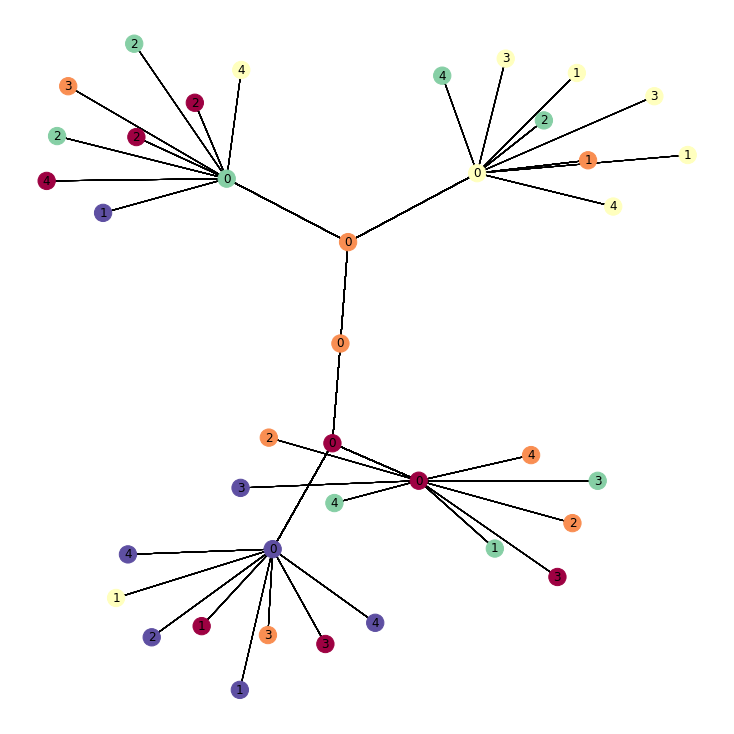

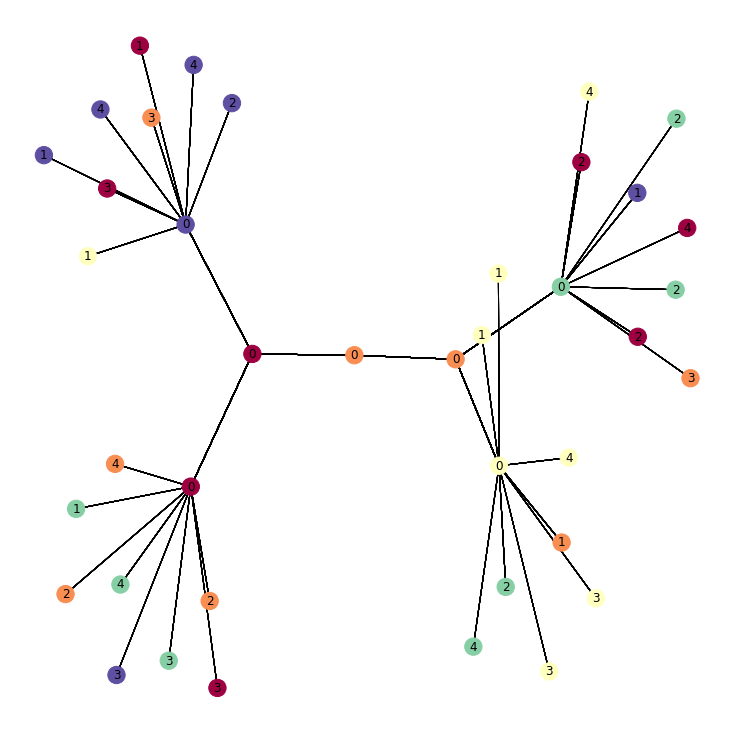

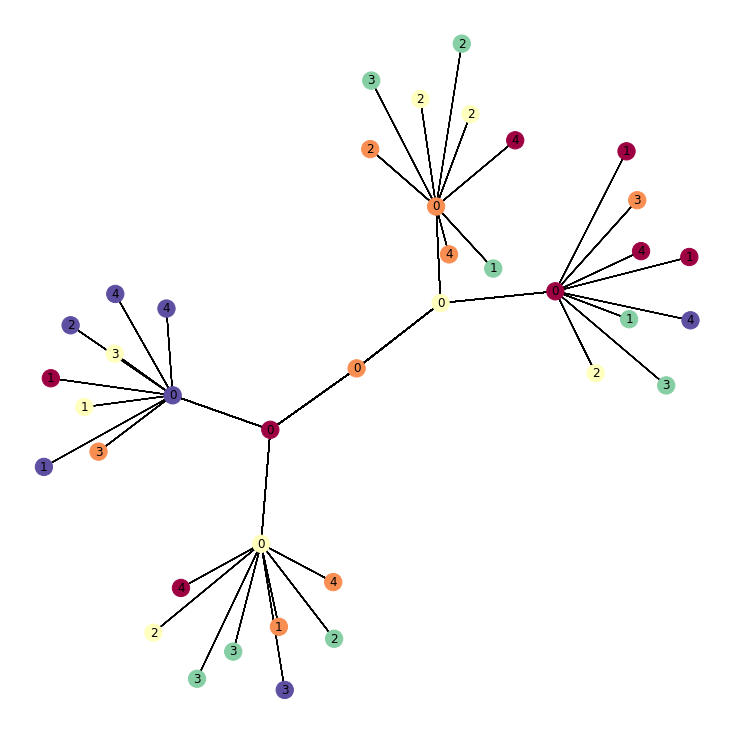

In [12]:
for i in range(10):
    ov = get_overlay_from_perm(cb.data[i][0])
    INP.overlay = ov
    draw_overlay_over_tenant(INP)